In [1]:
import pandas as pd
import numpy as np
import statsmodels as sts
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plot_summaries_path = './Data/plot_summaries.txt'
movie_metadata_path = './Data/movie.metadata.tsv'
character_metadata_path = './Data/character.metadata.tsv'
tv_tropes_path = './Data/tvtropes.clusters.txt'
name_clusters_path = './Data/name.clusters.txt'

In [4]:
plot_summaries = pd.read_csv(
    plot_summaries_path, sep='\t', header=None, names=['movie_wikipedia_id', 'plot_summary'])
movie_metadata = pd.read_csv(
    movie_metadata_path, sep='\t', header=None, 
    names=['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 
        'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'])
character_metadata = pd.read_csv(
    character_metadata_path, sep='\t', header=None,
    names=['movie_wikipedia_id', 'movie_freebase_id', 'movie_release_date', 
           'character_name', 'actor_dob', 'actor_gender', 'actor_height', 
           'actor_ethnicity','actor_name','actor_age', 'character_freebase_map', 
           'freebase_character_id', 'freebase_actor_id'])
tv_tropes = pd.read_csv(tv_tropes_path, sep='\t', header=None, names=['trope', 'data'])
name_clusters = pd.read_csv(name_clusters_path, sep='\t', header=None, names=['character_name', 'id'])

Let's look at films with plots in the dataset

In [5]:
plots_and_metadata = pd.merge(movie_metadata, plot_summaries, on='movie_wikipedia_id')

In [6]:
print(f'There are {len(plots_and_metadata)} movies with plots')

There are 42204 movies with plots


# Merging with external datasets

The main goal of the project is to extract features from plots with LLM and investigate which of them can predict success of the movie.

Thus, we should focus on the films with plots.

We can define movie success based on reviews and box office.

## Reviews

The most overlap with CMU movies provides IMDB dataset from their website https://developer.imdb.com/non-commercial-datasets/

Let's download and unpack corresponding files (they are ~300 MB)

In [7]:
if not os.path.isdir('Data/imdb'):
    os.mkdir('Data/imdb')

In [8]:
%%capture
!wget -P Data/imdb https://datasets.imdbws.com/title.basics.tsv.gz
!wget -P Data/imdb https://datasets.imdbws.com/title.ratings.tsv.gz

!gunzip Data/imdb/title.basics.tsv.gz
!gunzip Data/imdb/title.ratings.tsv.gz

In [9]:
imdb_title_basics = pd.read_csv('Data/imdb/title.basics.tsv', sep='\t')
imdb_title_ratings = pd.read_csv('Data/imdb/title.ratings.tsv', sep='\t')

In [10]:
imdb_title_basics = imdb_title_basics[['tconst', 'primaryTitle']]

In [11]:
imdb_merged = pd.merge(imdb_title_ratings, imdb_title_basics, on='tconst')
imdb_merged = imdb_merged.drop(columns=['tconst']).drop_duplicates(subset=['primaryTitle'])

In [12]:
cmu_with_reviews = pd.merge(imdb_merged, plots_and_metadata, left_on='primaryTitle', right_on='movie_name', how='right')
cmu_with_reviews = cmu_with_reviews.drop(columns=['primaryTitle'])

In [13]:
notna_rating_frac = cmu_with_reviews['averageRating'].notna().mean()
print(f'We have average IMDB rating for {notna_rating_frac * 100:.0f}% of films')

We have average IMDB rating for 82% of films


## Budgets & Revenue

In [14]:
bdgts = pd.read_csv("Data/movies_metadata.csv")
bdgts = bdgts[['budget', 'revenue', 'original_title']]

bdgts["budget"] = pd.to_numeric(bdgts['budget'], errors='coerce')
bdgts.dropna(subset=['budget'], inplace=True)
bdgts = bdgts.drop_duplicates(subset='original_title')

In [15]:
cmu_with_budgets = pd.merge(
    cmu_with_reviews, bdgts, left_on='movie_name', right_on='original_title', how='left') 

cmu_with_budgets['revenue'] = np.where(
    cmu_with_budgets['revenue_x'].notna(), 
    cmu_with_budgets['revenue_x'], 
    cmu_with_budgets['revenue_y']
)

cmu_with_budgets.drop(columns=['revenue_x', 'revenue_y', 'original_title'], inplace=True)

In [ ]:
plots_and_metadata = cmu_with_budgets.copy(deep=True).rename(
    columns={'averageRating': 'avg_rating', 'numVotes': 'n_votes'})

In [16]:
notna_revenue_frac = cmu_with_budgets['revenue'].notna().mean()
print(f'We have average IMDB rating for {notna_revenue_frac * 100:.0f}% of films')

We have average IMDB rating for 45% of films


In [17]:
notna_budget_frac = cmu_with_budgets['budget'].notna().mean()
print(f'We have average IMDB rating for {notna_budget_frac * 100:.0f}% of films')

We have average IMDB rating for 41% of films


# Exploratory Data Analysis

## Exploring plot summaries

In [19]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [20]:
def process_plot_summary(record):
    # print(f'plot_processing on record: {record}')
    try:
        plot_summary = record['plot_summary']
        word_count = len(plot_summary.split())
        char_count = len(plot_summary)
        avg_word_length = word_count / char_count if char_count else 0
        sentence_count = len(nltk.sent_tokenize(plot_summary))
        lexical_diversity = len(set(plot_summary.split())) / word_count if word_count else 0
        sentiment_polarity = TextBlob(plot_summary).sentiment.polarity

        return {
            "movie_wikipedia_id": record['movie_wikipedia_id'],
            "word_count": word_count,
            "char_count": char_count,
            "avg_word_length": avg_word_length,
            "sentence_count": sentence_count,
            "lexical_diversity": lexical_diversity,
            "sentiment_polarity": sentiment_polarity
        }
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None

In [21]:
results = []
records = plot_summaries.to_dict(orient='records')
failed = 0

with ThreadPoolExecutor(max_workers=12) as executor:
    future_to_record = {executor.submit(process_plot_summary, record): record for record in records}

    for future in as_completed(future_to_record):
        result = future.result()
        if result is not None:
            results.append(result)
        else:
            failed += 1

# Creating a new DataFrame from the processed data
processed_plot_summaries = pd.DataFrame(results)

processed_plot_summaries.head()

,movie_wikipedia_id,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity
0,595909,397,2425,0.163711,15,0.614610,0.063913
1,2940516,64,369,0.173442,3,0.828125,0.277778
2,1335380,782,4385,0.178335,36,0.539642,0.026543
3,31186339,778,4559,0.170651,52,0.560411,0.045261
4,24448645,79,458,0.172489,4,0.810127,-0.125000


In [22]:
processed_plot_summaries.describe()

,movie_wikipedia_id,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity
count,4.230300e+04,42303.000000,42303.000000,42303.000000,42303.000000,42303.000000,42303.000000
mean,1.497051e+07,310.740468,1784.034229,0.173003,15.693071,0.669059,0.046342
std,1.111994e+07,318.338286,1808.925536,0.010850,16.605600,0.132991,0.136427
min,3.300000e+02,4.000000,99.000000,0.037736,1.000000,0.254916,-1.000000
25%,4.565802e+06,87.000000,508.000000,0.167692,4.000000,0.560569,-0.022222
50%,1.284591e+07,187.000000,1079.000000,0.173667,9.000000,0.666667,0.040330
75%,2.485168e+07,454.000000,2604.500000,0.179435,23.000000,0.766667,0.116000
max,3.750192e+07,4929.000000,28159.000000,0.239316,344.000000,1.000000,1.000000


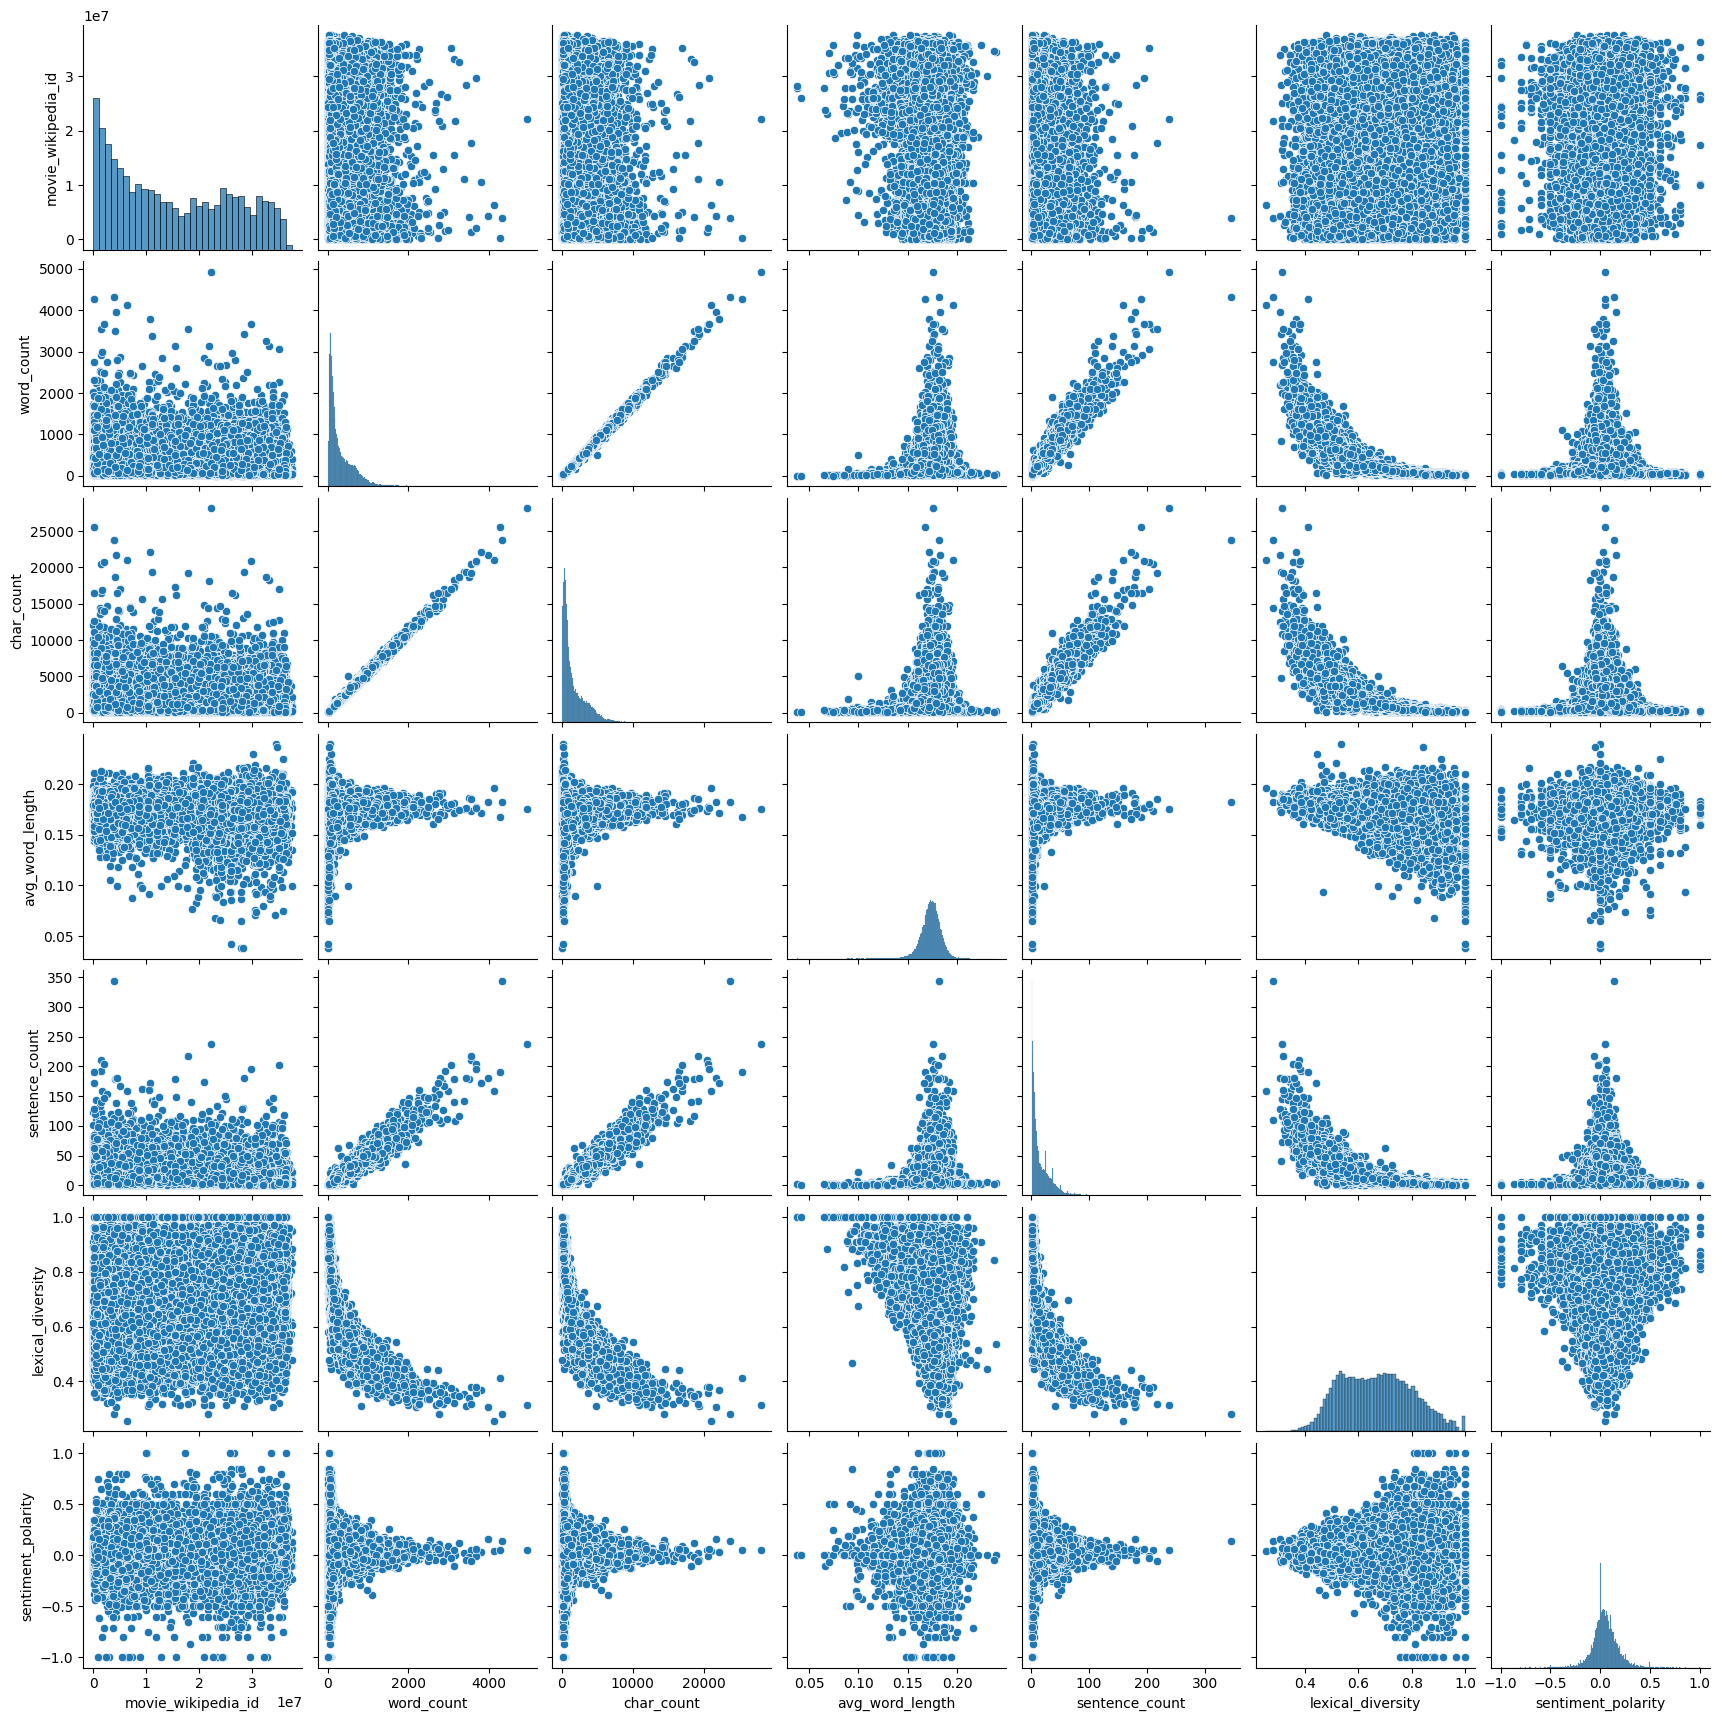

In [23]:
sns.pairplot(processed_plot_summaries)

## Exploring Movie Metadata

In [24]:
plots_and_metadata['release_date'] = plots_and_metadata['release_date'].astype(str)
plots_and_metadata['release_date'] = plots_and_metadata['release_date'].str.slice(0, 4)
plots_and_metadata['release_date'].replace('nan', np.nan, inplace=True)

In [25]:
# calculating % of missing data across all features
missing_percentage = plots_and_metadata.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
avg_rating            18.282627
n_votes               18.282627
movie_wikipedia_id     0.000000
movie_freebase_id      0.000000
movie_name             0.000000
release_date           6.203203
runtime               15.695195
languages              0.000000
countries              0.000000
genres                 0.000000
plot_summary           0.000000
budget                58.529997
revenue               55.286229
dtype: float64


**Comment:** after merging with external data, 55% of box office revenue data is missing. We also lack information about runtime for approximately 15% of the movies. If we are to assign each movie to a year, we could either drop the columns missing release_date, or scrape the relevant information from online

Let's clean columns with json values: [] and {} might mean missing value, but it cannot be observed with `.isna()` method

In [26]:
values_to_replace = ['{}', '[]', '', 'NA', 'N/A', '-']
replace_map = {value: np.nan for value in values_to_replace}
movie_metadata_adj = plots_and_metadata.replace(replace_map)

missing_percentage_adj = movie_metadata_adj.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage_adj)

Percentage of Missing Values per Column:
avg_rating            18.282627
n_votes               18.282627
movie_wikipedia_id     0.000000
movie_freebase_id      0.000000
movie_name             0.000000
release_date           6.203203
runtime               15.695195
languages             12.472751
countries              7.847597
genres                 0.973841
plot_summary           0.000000
budget                58.529997
revenue               55.286229
dtype: float64


Let's check if we have duplicates and drop them

In [27]:
print(f'Rows before duplicate removal: {len(plots_and_metadata)}')

plots_and_metadata = plots_and_metadata.drop_duplicates(subset=['movie_wikipedia_id'], keep='first')
plots_and_metadata = plots_and_metadata.drop_duplicates(subset=['movie_freebase_id'], keep='first')

print(f'Rows after duplicate removal: {len(plots_and_metadata)}')

Rows before duplicate removal: 42204
Rows after duplicate removal: 42204


## Exploring Character Metadata

In [28]:
# calculating % of missing data across all features
missing_percentage = character_metadata.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
movie_wikipedia_id         0.000000
movie_freebase_id          0.000000
movie_release_date         2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
character_freebase_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


**Comments:** we have a lot of missing values across each feature

## Exploring TV Tropes

In [29]:
tv_tropes.head(10)

,trope,data
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
5,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
6,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
7,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
8,adventurer_archaeologist,"{""char"": ""Evelyn Carnahan-O'Connell"", ""movie"":..."
9,arrogant_kungfu_guy,"{""char"": ""Han"", ""movie"": ""Enter the Dragon"", ""..."


Let's unpack `data` column which is in form of json

In [30]:
import json

tv_tropes['data'] = tv_tropes['data'].apply(json.loads)
expanded_data = tv_tropes['data'].apply(pd.json_normalize)

tv_tropes = tv_tropes.join(pd.concat(expanded_data.values).reset_index(drop=True))
tv_tropes.drop('data', axis=1, inplace=True)
tv_tropes = tv_tropes.rename(columns={'char': 'character_name', 'movie': 'movie_name', 'id': 'character_freebase_map', 'actor': 'actor_name'})

tv_tropes.head(10)

,trope,character_name,movie_name,character_freebase_map,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


In [31]:
# calculating % of missing data across all features
missing_percentage = tv_tropes.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
trope                     0.0
character_name            0.0
movie_name                0.0
character_freebase_map    0.0
actor_name                0.0
dtype: float64
